## Prepaiting data and training CRF 

In [5]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import sys

In [6]:
import torch

device = torch.device('cuda')
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

GeForce RTX 2080 Ti


In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import json

In [4]:
!pip install sklearn_crfsuite

You should consider upgrading via the 'pip install --upgrade pip' command.


In [8]:
from logger import initialize_logger
logger = initialize_logger('../workdir/logs/biomed_ie.log', 'biomed_ie')

In [9]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from pytorch_transformers import AdamW, WarmupLinearSchedule

In [6]:
!pip install pyprind

You should consider upgrading via the 'pip install --upgrade pip' command.


In [10]:
import math
import warnings
import pyprind

In [11]:
ner_data = pd.read_csv("../data/conll2003/eng.train.txt", sep=" ", header=None, skip_blank_lines=False, encoding="utf-8")
ner_data.columns = ["token", "pos", "chunk", "ne"]

# Explore the distribution of NE tags in the dataset
tag_distribution = ner_data.groupby("ne").size().reset_index(name='counts')
print(tag_distribution)

       ne  counts
0   B-LOC      11
1  B-MISC      37
2   B-ORG      24
3   I-LOC    8286
4  I-MISC    4556
5   I-ORG   10001
6   I-PER   11128
7       O  168346


In [12]:
classes = list(filter(lambda x: x not in ["O", np.nan], list(ner_data["ne"].unique())))
print(classes)

['I-ORG', 'I-MISC', 'I-PER', 'I-LOC', 'B-LOC', 'B-MISC', 'B-ORG']


In [13]:
sentences, sentence = [], []
pbar = pyprind.ProgBar(len(ner_data))

for index, row in ner_data.iterrows():
    # If the row is empty (no string in the token column)
    if type(row["token"]) != str:
        # If the current sentence is not empty, append it to the sentences and create a new sentence
        if len(sentence) > 0:
            sentences.append(sentence)
            sentence = []
    else:
        # If the row does not indicate the start of a document, add the token to the current sentence
        if type(row["token"]) != float and type(row["pos"]) != float and type(row["ne"]) != float:
            if not row["token"].startswith("-DOCSTART-"):
                sentence.append([row["token"], row["pos"], row["chunk"], row["ne"]])
    pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:29


In [14]:
def word_features(sentence, i, use_chunks=False):
    # Get the current word and POS
    word = sentence[i][0]
    pos = sentence[i][1]
    
    features = { "bias": 1.0,
                 "word.lower()": word.lower(),
                 "word[-3:]": word[-3:],
                 "word[-2:]": word[-2:],
                 "word.isupper()": word.isupper(),
                 "word.istitle()": word.istitle(),
                 "word.isdigit()": word.isdigit(),
                 "pos": pos,
                 "pos[:2]": pos[:2],
               }
    # If chunks are being used, add the current chunk to the feature dictionary
    if use_chunks:
        chunk = sentence[i][2]
        features.update({ "chunk": chunk })
    # If this is not the first word in the sentence...
    if i > 0:
        # Get the sentence's previous word and POS
        prev_word = sentence[i-1][0]
        prev_pos = sentence[i-1][1]
        # Add characteristics of the sentence's previous word and POS to the feature dictionary
        features.update({ "-1:word.lower()": prev_word.lower(),
                          "-1:word.istitle()": prev_word.istitle(),
                          "-1:word.isupper()": prev_word.isupper(),
                          "-1:pos": prev_pos,
                          "-1:pos[:2]": prev_pos[:2],
                        })
        # If chunks are being used, add the previous chunk to the feature dictionary
        if use_chunks:
            prev_chunk = sentence[i-1][2]
            features.update({ "-1:chunk": prev_chunk })
    # Otherwise, add 'BOS' (beginning of sentence) to the feature dictionary
    else:
        features["BOS"] = True
    # If this is not the last word in the sentence...
    if i < len(sentence)-1:
        # Get the sentence's next word and POS
        next_word = sentence[i+1][0]
        next_pos = sentence[i+1][1]
        # Add characteristics of the sentence's previous next and POS to the feature dictionary
        features.update({ "+1:word.lower()": next_word.lower(),
                          "+1:word.istitle()": next_word.istitle(),
                          "+1:word.isupper()": next_word.isupper(),
                          "+1:pos": next_pos,
                          "+1:pos[:2]": next_pos[:2],
                        })
        # If chunks are being used, add the next chunk to the feature dictionary
        if use_chunks:
            next_chunk = sentence[i+1][2]
            features.update({ "+1:chunk": next_chunk })
    # Otherwise, add 'EOS' (end of sentence) to the feature dictionary
    else:
        features["EOS"] = True
    # Return the feature dictionary
    return features

In [15]:
def sentence_features(sentence, use_chunks=False):
    return [word_features(sentence, i, use_chunks) for i in range(len(sentence))]

# Return the label (NER tag) for each word in a given sentence
def sentence_labels(sentence):
    return [label for token, pos, chunk, label in sentence]

In [16]:
from sklearn.model_selection import train_test_split
X = [sentence_features(sentence) for sentence in sentences]
y = [sentence_labels(sentence) for sentence in sentences]

# Split X and y into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("First token features:\n{}\n{}".format("-"*21, X_train[0][0]))
print("\nFirst token label:\n{}\n{}".format("-"*18, y_train[0][0]))

First token features:
---------------------
{'bias': 1.0, 'word.lower()': 'the', 'word[-3:]': 'The', 'word[-2:]': 'he', 'word.isupper()': False, 'word.istitle()': True, 'word.isdigit()': False, 'pos': 'DT', 'pos[:2]': 'DT', 'BOS': True, '+1:word.lower()': 'entire', '+1:word.istitle()': False, '+1:word.isupper()': False, '+1:pos': 'JJ', '+1:pos[:2]': 'JJ'}

First token label:
------------------
O


In [17]:
for i in range(len(y_train)):
    y_train[i] = np.where(y_train[i] == 'B-LOC', 'I-LOC', y_train[i])
    y_train[i] = np.where(y_train[i] == 'B-LOC', 'I-LOC', y_train[i])
    y_train[i] = np.where(y_train[i] == 'B-MISC', 'I-MISC', y_train[i])
    y_train[i] = np.where(y_train[i] == 'B-ORG', 'I-ORG', y_train[i])
    
for i in range(len(y_test)):
    y_test[i] = np.where(y_test[i] == 'B-LOC', 'I-LOC', y_test[i])
    y_test[i] = np.where(y_test[i] == 'B-LOC', 'I-LOC', y_test[i])
    y_test[i] = np.where(y_test[i] == 'B-MISC', 'I-MISC', y_test[i])
    y_test[i] = np.where(y_test[i] == 'B-ORG', 'I-ORG', y_test[i])

In [18]:
X_lens = [len(X_train[i]) for i in range(len(X_train))]
y_lens = [len(y_train[i]) for i in range(len(y_train))]
X_lens == y_lens

True

In [19]:
X_lens = [len(X_test[i]) for i in range(len(X_test))]
y_lens = [len(y_test[i]) for i in range(len(y_test))]
X_lens == y_lens

True

In [18]:
crf = sklearn_crfsuite.CRF(algorithm="lbfgs",
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=True)

# Train the CRF model on the supplied training data
%timeit crf.fit(X_train, y_train)

20.6 s ± 68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
classes = ['I-ORG', 'I-MISC', 'I-PER', 'I-LOC']
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_test, y_pred, labels=classes))

              precision    recall  f1-score   support

       I-ORG       0.90      0.87      0.89      2090
      I-MISC       0.93      0.84      0.88       937
       I-PER       0.93      0.94      0.94      2220
       I-LOC       0.91      0.92      0.92      1616

   micro avg       0.92      0.90      0.91      6863
   macro avg       0.92      0.90      0.91      6863
weighted avg       0.92      0.90      0.91      6863



## AL setup

In [17]:
#!pip install seqeval

In [73]:
#!pip uninstall -y libact
#!pip install git+https://github.com/IINemo/libact.git@seq

In [72]:
#!pip uninstall -y actleto
#!pip install git+https://github.com/IINemo/active_learning_toolbox.git@seq

In [ ]:
#!pip install git+https://github.com/IINemo/bert_sequence_tagger.git

In [27]:
#!pip install flair

[autoreload of _pytest.assertion failed: Traceback (most recent call last):
  File "/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/opt/.pyenv/versions/3.7.4/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/opt/.pyenv/versions/3.7.4/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/_pytest/assertion/__init__.py", line 12, in <module>
    from _pytest.assertion.rewrite import

In [20]:
import click
import pandas as pd
import numpy as np
import itertools
import os
import re
import torch
#from seqeval.metrics import f1_score

from libact.query_strategies import UncertaintySampling, RandomSampling
from active_learning_seq import RandomSamplingWithRetraining

from actleto import ActiveLearner, make_libact_strategy_ctor

from libact.base.dataset import Dataset

from biomed_ie.packages.vadim_ml.memoize import memoize
from biomed_ie.packages.vadim_ml.io import load_file, dump_file

from flair_libact import PositiveLessCertain

/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/.pyenv/versions/3.7.4/lib/python3.7/site-packages/tensorflow/pyth

In [21]:
def append_to_file(path, val):
    with open(path, 'a') as f:
        print(str(val), file=f, end='\n')

In [22]:
from libact.base.interfaces import ProbabilisticModel

class CRF_active(ProbabilisticModel):

    def __init__(self, *args, **kwargs):
        self.model = sklearn_crfsuite.CRF(*args, **kwargs)

    def train(self, libact_dataset, indexes=None):
        if indexes is not None:
            libact_dataset = Dataset([libact_dataset.data[i][0] for i in indexes], 
                                     [libact_dataset.data[i][1] for i in indexes])

        X, y = libact_dataset.format_sklearn()
        return self.model.fit(X, y)

    def predict(self, feature, *args, **kwargs):
        pred = self.model.predict(feature, *args, **kwargs)
        #pred_list = list(map(list, pred))
        #print(pred_list[0])
        return pred

    def score(self, X, y, *args, **kwargs):
        #return self.model.score(X, y, **kwargs)
        pass

    def predict_proba(self, X, *args, **kwargs):
        #all_labels = self.model.predict_marginals(X, *args, **kwargs)
        #return [[max(dict_.values()) for dict_ in l] for l in all_labels]
        all_labels = self.model.predict_marginals(X, *args, **kwargs)
        #maxlen = max(map(len, all_labels))
        #out = [np.mean(np.log([max(dict_.values()) for dict_ in l])) for l in all_labels]
        #print([[dict_.values() for dict_ in l] for l in all_labels][0])
        #print([[max(dict_.values()) for dict_ in l] for l in all_labels][0])
        out = [np.mean([max(dict_.values()) for dict_ in l]) for l in all_labels]

        return np.array(out).reshape(-1, 1)

    
    #def fit(self, libact_dataset, *args, **kwargs):
        #dataset = libact_dataset.format_sklearn()
        #return self.model.fit(dataset, **kwargs)

In [23]:
class ActiveLearner1(object):
    """The class that implements active learning logic."""
    
    def __init__(self, 
                 active_learn_alg_ctor,
                 X_full_dataset, 
                 y_dtype='int',
                 y_full_dataset = None, 
                 model_evaluate = None,
                 X_test_dataset = None,
                 y_test_dataset = None,
                 eval_metrics = None,
                 rnd_start_steps = 0,
                 rnd_start_samples = 10): 
        """ActiveLearner constructor.
        
        Args:
            active_learn_alg_ctor (functor): functor object that returns active learning strategy.
            X_full_dataset (np.array or sparse matrix): feature matrix.
            y_dtype: type of y labels.
            y_full_dataset (np.array): known answers (e.g., None -- unknown, True -- positive class, False -- negative class) 
            model_evaluate: the model that will be evaluated on the holdout.
            X_test_dataset: feature matrix for testing via holdout.
            y_test_dataset: y labels for testing via holdout.
            eval_metrics (list): list of sklearn evaluation metrics.
            rnd_start_steps: AL will can make several seed steps by choosing random samples (without model suggestions).
            logger (logging.Logger): the object for logging.
            
        """
        super().__init__()
        
        self._y_dtype = y_dtype
        self._model_evaluate = model_evaluate
        self._eval_metrics = eval_metrics
        
        self._X_full_dataset = X_full_dataset
        if y_full_dataset is not None:
            self._y_full_dataset = y_full_dataset # TODO: validate dimentions
        else:
            self._y_full_dataset = [None] * self._X_full_dataset.shape[0]
            
        self._active_learn_algorithm = active_learn_alg_ctor(self._X_full_dataset, 
                                                             self._y_full_dataset)
        
        self._X_test_dataset = X_test_dataset
        self._y_test_dataset = y_test_dataset
        
        self._iteration_num = 0
        self._rnd_start_steps = rnd_start_steps
        self._rnd_start_samples = rnd_start_samples

    def _select_unannotated(self, labels):
        return np.where([(e is None) for e in labels])[0]
    
    def start(self):
        self._active_learn_algorithm.start()

    def choose_random_sample_for_annotation(self, number):
        return np.random.choice(self._select_unannotated(self._y_full_dataset), 
                                size = number, 
                                replace = False)
        
    def choose_samples_for_annotation(self):
        if self._iteration_num < self._rnd_start_steps:
            return self.choose_random_sample_for_annotation(self._rnd_start_samples)
        else:
            return self._active_learn_algorithm.choose_samples_for_annotation()
    
    def evaluate(self, fit_model=True):
        if self._model_evaluate is None:
            return None
        
        if fit_model:
            selector = [False for _ in range(len(self._y_full_dataset))]
            for ind, answ in enumerate(self._y_full_dataset):
                if answ is None:
                    selector[ind] = False
                elif all(e is None for e in self._y_full_dataset):
                    selector[ind] = False
                else:
                    selector[ind] = True
            
            y_fit = np.array(self._y_full_dataset)[selector]
            #y_fit = [e for e in self._y_full_dataset if e is not None]
            #y_fit = pd.Series(self._y_full_dataset)
            #y_fit = y_fit[y_fit.notnull()].astype(self._y_dtype)
            
            logger.info('Number of training samples: {}'.format(len(y_fit)))
            
            self._model_evaluate.train(Dataset(self._X_full_dataset, self._y_full_dataset), np.ravel(np.argwhere(np.array(selector) == True)))
        
        preds = self._model_evaluate.predict(self._X_test_dataset)
        return {metric.__name__ : metric(preds, self._y_test_dataset) 
                for metric in self._eval_metrics}
    
    def get_annotation(self):
        return self._y_full_dataset
    
    def make_iteration(self, indexes, answers):
        self._iteration_num += 1
        
        selector = [False for _ in range(answers.shape[0])]
        for ind, answ in enumerate(answers):
            if answ is None:
                selector[ind] = False
            elif all(e is None for e in answ):
                selector[ind] = False
            else:
                selector[ind] = True
                
        #selector = ((answers == np.array(None)).sum(axis=1) == 0)
        answers = answers[selector]
        indexes = np.array(indexes)[selector]
        #print(indexes)
#         with open('tmp_log.log', 'w') as f:
#             f.write(str(indexes))
        for num, i in enumerate(indexes):
            self._y_full_dataset[i] = answers[num]

        return self._active_learn_algorithm.make_iteration(indexes, answers)

In [24]:
def emulate_active_learning(train_tags, active_learner, 
                            max_iterations=12, 
                           fit_model=False):
    print('Start emulating active learning.')
    statistics = []
    active_learner.start()
    perf = active_learner.evaluate(fit_model=False)
    statistics.append(perf)
    print('Evaluation:', perf)

    
    for i in range(max_iterations):
        print('Active learning iteration: #{}'.format(i))
        samples_to_annotate = active_learner.choose_samples_for_annotation()
        annotations = np.array([train_tags[idx] for idx in samples_to_annotate])
        #print(len(annotations))
        active_learner.make_iteration(samples_to_annotate, annotations)
        perf = active_learner.evaluate(fit_model=True)
        statistics.append(perf)
        print('Performance:', perf)
    
    return statistics

In [25]:
def y_train2y_seed(y_train, n_seeds_per_class=10):
    y_vals = set(tag for row in y_train for tag in row)
    
    indexes = np.array(range(len(y_train)))
    known_indexes = []
    for label in y_vals:
        selected_indices = indexes[[label in y for y in y_train]]
        known_indexes += list(np.random.choice(selected_indices, size=n_seeds_per_class))

    known_indexes = list(set(known_indexes))
    tags_seed = [None for _ in range(len(y_train))]

    for i in known_indexes:
        tags_seed[i] = y_train[i]

    Y_seed = tags_seed
    
    return Y_seed

In [26]:
"""Metrics to assess performance on sequence labeling task given prediction
Functions named as ``*_score`` return a scalar value to maximize: the higher
the better
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from collections import defaultdict

import numpy as np

def get_entities(seq, suffix=False):
    """Gets entities from sequence.
    Args:
        seq (list): sequence of labels.
    Returns:
        list: list of (chunk_type, chunk_start, chunk_end).
    Example:
        >>> from seqeval.metrics.sequence_labeling import get_entities
        >>> seq = ['B-PER', 'I-PER', 'O', 'B-LOC']
        >>> get_entities(seq)
        [('PER', 0, 1), ('LOC', 3, 3)]
    """
            
    if any(isinstance(s, list) for s in seq):
        seq = [item for sublist in seq for item in sublist + ['O']]

    prev_tag = 'O'
    prev_type = ''
    begin_offset = 0
    chunks = []
    for i, chunk in enumerate(seq + ['O']):
        if suffix:
            tag = chunk[-1]
            type_ = chunk.split('-')[0]
        else:
            tag = chunk[0]
            type_ = chunk.split('-')[-1]

        if end_of_chunk(prev_tag, tag, prev_type, type_):
            chunks.append((prev_type, begin_offset, i-1))
        if start_of_chunk(prev_tag, tag, prev_type, type_):
            begin_offset = i
        prev_tag = tag
        prev_type = type_

    return chunks


def end_of_chunk(prev_tag, tag, prev_type, type_):
    """Checks if a chunk ended between the previous and current word.
    Args:
        prev_tag: previous chunk tag.
        tag: current chunk tag.
        prev_type: previous type.
        type_: current type.
    Returns:
        chunk_end: boolean.
    """
    chunk_end = False

    if prev_tag == 'E': chunk_end = True
    if prev_tag == 'S': chunk_end = True

    if prev_tag == 'B' and tag == 'B': chunk_end = True
    if prev_tag == 'B' and tag == 'S': chunk_end = True
    if prev_tag == 'B' and tag == 'O': chunk_end = True
    if prev_tag == 'I' and tag == 'B': chunk_end = True
    if prev_tag == 'I' and tag == 'S': chunk_end = True
    if prev_tag == 'I' and tag == 'O': chunk_end = True

    if prev_tag != 'O' and prev_tag != '.' and prev_type != type_:
        chunk_end = True

    return chunk_end


def start_of_chunk(prev_tag, tag, prev_type, type_):
    """Checks if a chunk started between the previous and current word.
    Args:
        prev_tag: previous chunk tag.
        tag: current chunk tag.
        prev_type: previous type.
        type_: current type.
    Returns:
        chunk_start: boolean.
    """
    chunk_start = False

    if tag == 'B': chunk_start = True
    if tag == 'S': chunk_start = True

    if prev_tag == 'E' and tag == 'E': chunk_start = True
    if prev_tag == 'E' and tag == 'I': chunk_start = True
    if prev_tag == 'S' and tag == 'E': chunk_start = True
    if prev_tag == 'S' and tag == 'I': chunk_start = True
    if prev_tag == 'O' and tag == 'E': chunk_start = True
    if prev_tag == 'O' and tag == 'I': chunk_start = True

    if tag != 'O' and tag != '.' and prev_type != type_:
        chunk_start = True

    return chunk_start


def f1_score(y_true, y_pred, average='micro', suffix=False):
    """Compute the F1 score.
    The F1 score can be interpreted as a weighted average of the precision and
    recall, where an F1 score reaches its best value at 1 and worst score at 0.
    The relative contribution of precision and recall to the F1 score are
    equal. The formula for the F1 score is::
        F1 = 2 * (precision * recall) / (precision + recall)
    Args:
        y_true : 2d array. Ground truth (correct) target values.
        y_pred : 2d array. Estimated targets as returned by a tagger.
    Returns:
        score : float.
    Example:
        >>> from seqeval.metrics import f1_score
        >>> y_true = [['O', 'O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'O'], ['B-PER', 'I-PER', 'O']]
        >>> y_pred = [['O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'O'], ['B-PER', 'I-PER', 'O']]
        >>> f1_score(y_true, y_pred)
        0.50
    """
    true_entities = set(get_entities(y_true, suffix))
    y_pred = list(map(list, y_pred))
    pred_entities = set(get_entities(y_pred, suffix))
    
    nb_correct = len(true_entities & pred_entities)
    nb_pred = len(pred_entities)
    nb_true = len(true_entities)

    p = nb_correct / nb_pred if nb_pred > 0 else 0
    r = nb_correct / nb_true if nb_true > 0 else 0
    score = 2 * p * r / (p + r) if p + r > 0 else 0
    

    return score

In [27]:
strategies_to_try = {
    'uncertainty': lambda trn_ds, libact_model: UncertaintySampling(trn_ds, model=libact_model, method='lc'),
    'random': lambda trn_ds, libact_model: RandomSamplingWithRetraining(trn_ds, model=libact_model, method='lc'),
    #'positivelesscertain': lambda tr_ds, libact_model: UncertaintySampling(tr_ds, model=PositiveLessCertain(libact_model), method='lc')
}

In [ ]:
max_samples_number = 50
repeats = 5
active_iterations = 50
N_SAMPLES_PER_AL_ITER = 50

for repeat in range(repeats):
    for strat_name, strat in strategies_to_try.items():
        
        path = os.path.join('../workdir/experiments/crf_50seed/', strat_name)
        if os.path.exists(os.path.join(path, f'statistics{repeat}.json')):
            print(f'statistics{repeat}.json already exists. Next')
            continue
    
        print('Active learning strategy', strat_name)
        print('Repeat', repeat)
    
        y_seed = y_train2y_seed(y_train, n_seeds_per_class=10)
        
        selector = [False for _ in range(len(y_seed))]
        for ind, answ in enumerate(y_seed):
            if answ is None:
                selector[ind] = False
            elif all(e is None for e in y_seed):
                selector[ind] = False
            else:
                selector[ind] = True
            
        y_nonempty = np.array(y_seed)[selector]
        
        print(len(y_nonempty))
        
        max_samples_number = int((len(y_seed) - len(y_nonempty)) * 0.02)
        
        print(max_samples_number)
    
        active_tagger = CRF_active(algorithm="lbfgs",
              c1=0.1,
              c2=0.1,
              max_iterations=100,
              all_possible_transitions=True)
        
        active_learn_alg_ctor = make_libact_strategy_ctor(lambda tr_ds: strat(tr_ds, active_tagger), max_samples_number=max_samples_number)
        
        active_learner = ActiveLearner1(active_learn_alg_ctor = active_learn_alg_ctor,
                                y_dtype = 'str',
                                X_full_dataset = X_train, 
                                y_full_dataset = y_seed,
                                X_test_dataset = X_test,
                                y_test_dataset = y_test,
                                model_evaluate=active_tagger,
                                eval_metrics=[f1_score],
                                rnd_start_steps=0,
                                rnd_start_samples=max_samples_number)                
            
        statistics = emulate_active_learning(y_train, active_learner, max_iterations=active_iterations)
        dump_file(statistics, path, f'statistics{repeat}.json')

Active learning strategy uncertainty
Repeat 0
49
223
Start emulating active learning.
Evaluation: {'f1_score': 0.5014189041693953}
Active learning iteration: #0
2020-04-01 19:40:13,856 - biomed_ie - INFO - Number of training samples: 272
Performance: {'f1_score': 0.511156186612576}
Active learning iteration: #1
2020-04-01 19:40:17,339 - biomed_ie - INFO - Number of training samples: 495
Performance: {'f1_score': 0.5864509605662286}
Active learning iteration: #2
2020-04-01 19:40:20,741 - biomed_ie - INFO - Number of training samples: 718
Performance: {'f1_score': 0.6210373025652515}
Active learning iteration: #3
2020-04-01 19:40:24,305 - biomed_ie - INFO - Number of training samples: 941
Performance: {'f1_score': 0.6786740331491713}
Active learning iteration: #4
2020-04-01 19:40:28,095 - biomed_ie - INFO - Number of training samples: 1164
Performance: {'f1_score': 0.7202130019968938}
Active learning iteration: #5
2020-04-01 19:40:32,247 - biomed_ie - INFO - Number of training samples: 1

## Plotting results

In [2]:
%matplotlib inline

In [3]:
from itertools import cycle
from matplotlib import pyplot as plt
import os
import json
import numpy as np


def generate_plot(np_stats, color_bg, color_line, marker, label, metric_dim=0):
    if len(np_stats.shape) > 2:
        np_stats = np_stats[:, :, metric_dim]
    
    disp = np_stats.std(axis=0)
    means = np_stats.mean(axis=0)
    
    x = list(range(0, means.shape[0]))

    line_thikness = 0.5
    plt.fill_between(x, means - disp, means + disp, color=color_bg, alpha=0.5)
    plt.xticks(range(0, means.shape[0] + 2, 5))
    return plt.plot(x, means, color=color_line, label=label, 
                    marker=marker, linewidth=line_thikness)


def create_chart(expert_dir, attr_type, metric_dim=0, save_dir=None):
    fig = plt.figure(num=None, figsize=(8, 6), 
                     dpi=200, facecolor='w', edgecolor='k')
    plt_list = []
    
    color_pool = cycle([('red', 'darksalmon', 'o'), 
                        ('midnightblue', 'skyblue', 'v'), 
                        ('g', 'lightgreen', 's'), 
                        #('gold', 'palegoldenrod', '*'),
                        ('maroon', 'rosybrown', '*'),
                        ('purple', 'violet', '+'),
                        ('slategrey', 'lightgrey', '1'),
                        ('darkorange', 'wheat', 's'),
                        ('darkcyan', 'lightcyan', 'P')])
    

    for stratname in sorted(os.listdir(expert_dir)):
        #noext = os.path.splitext(filename)[0]
        #if '.' in noext:
            #continue
        
        #f_strat = noext
        
        all_stats = []
        
        color = next(color_pool)
        folder_path = os.path.join(expert_dir, stratname)
        print(folder_path)
        for file in sorted(os.listdir(folder_path))[1:]:
            file_path = os.path.join(folder_path, file)
            #print(file_path)
            with open(file_path) as f:
                stats = np.array([np.array(stat['f1_score']) for stat in json.load(f)])
            all_stats.append(stats)
        
        chart, = generate_plot(np.array(all_stats), 
                                   color_bg=color[1], 
                                   color_line=color[0], 
                                   marker=color[2],
                                   label=stratname,
                                   metric_dim=metric_dim)
        plt_list.append(chart)
        
    plt.legend(handles=plt_list, loc='lower right', fontsize='x-large')
    plt.ylabel('Performance, F1', fontdict={'size' : 15})
    plt.xlabel('AL iteration, #', fontdict={'size' : 15})
    plt.tick_params(labelsize=12)
    
    if save_dir is not None:
        plt.savefig(os.path.join(save_dir, f'{attr_type}.png'))
        
    plt.show()

../workdir/experiments/crf_200seed/random
../workdir/experiments/crf_200seed/uncertainty


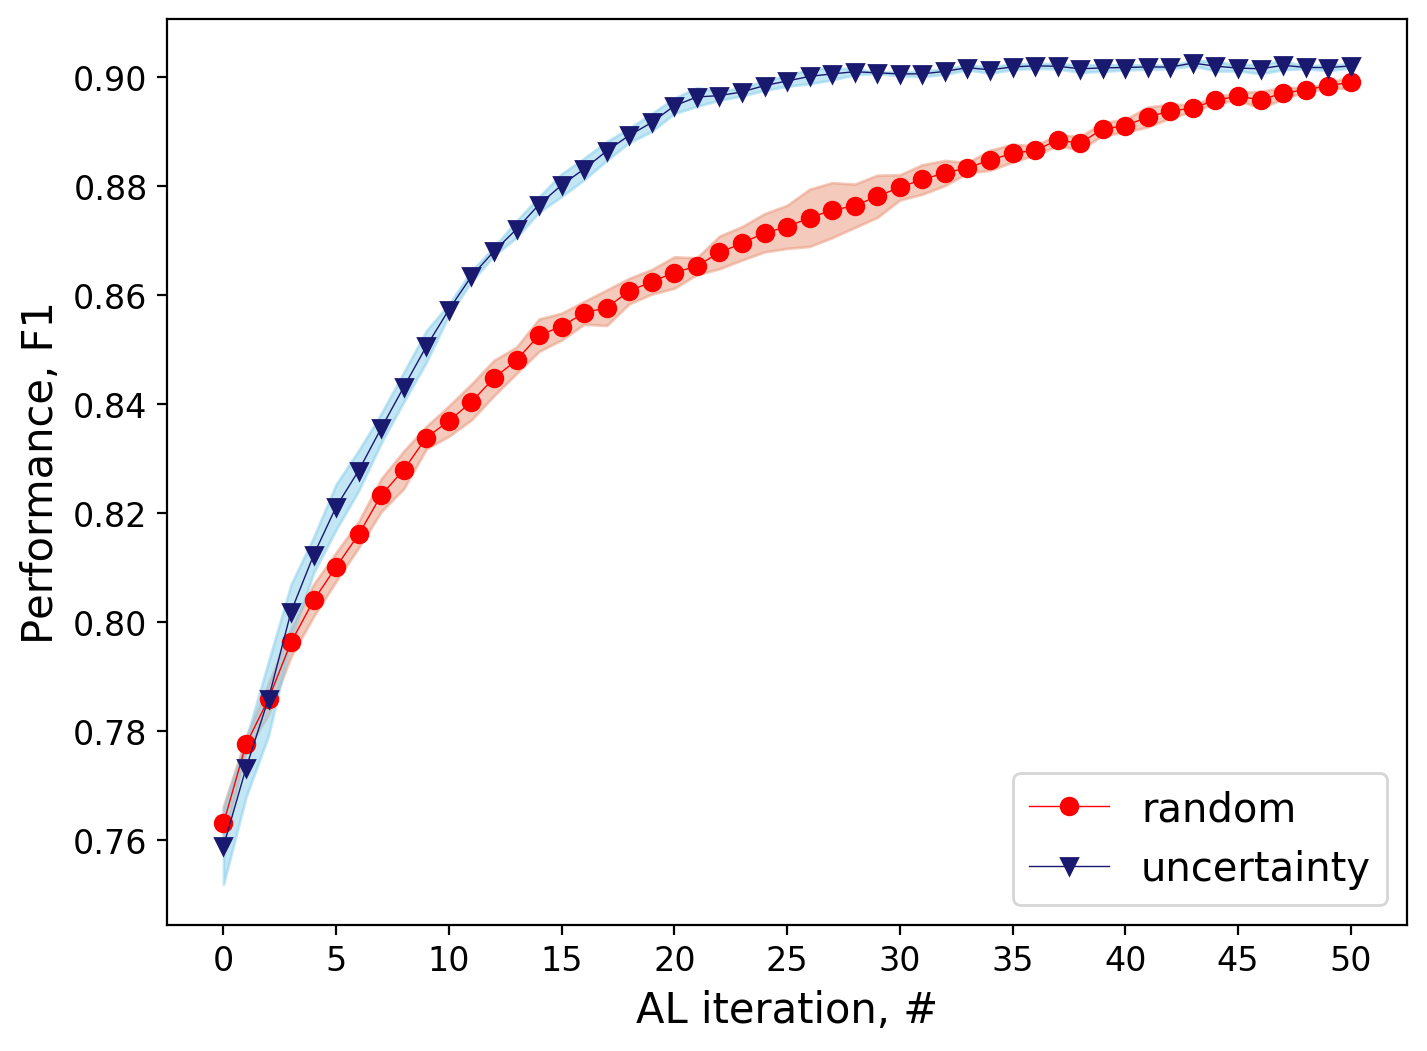

In [4]:
#from generate_chart import create_chart
create_chart('../workdir/experiments/crf_200seed', 'crf', save_dir='../workdir/')

../workdir/experiments/crf_10/random
../workdir/experiments/crf_10/uncertainty


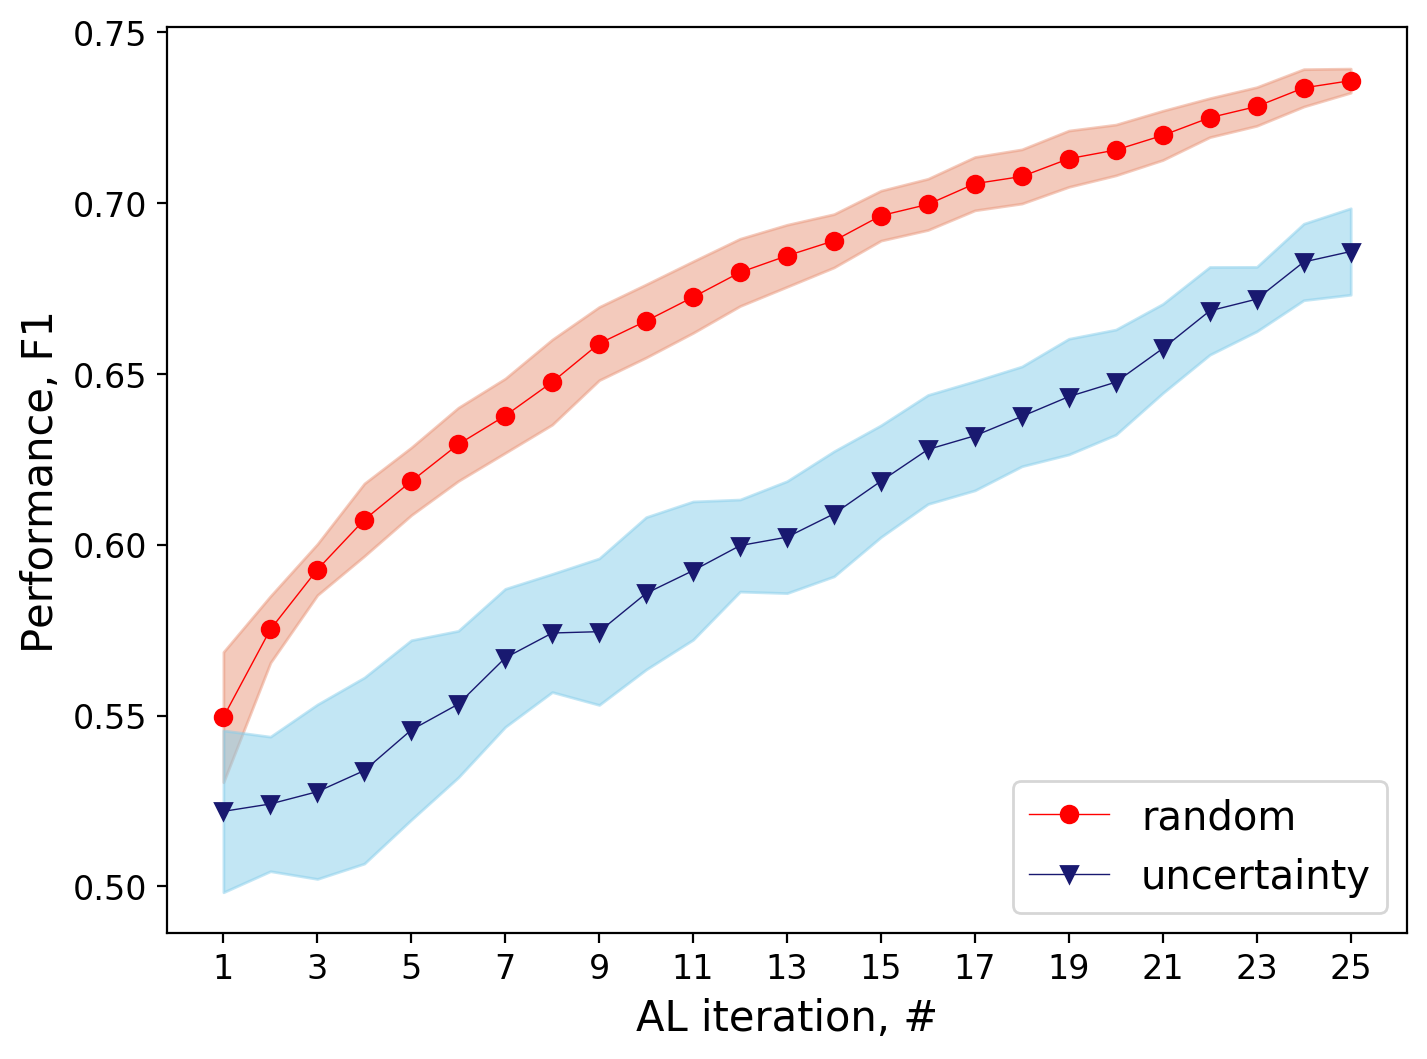

In [80]:
create_chart('../workdir/experiments/crf_10', 'crf_10', save_dir='../workdir/')

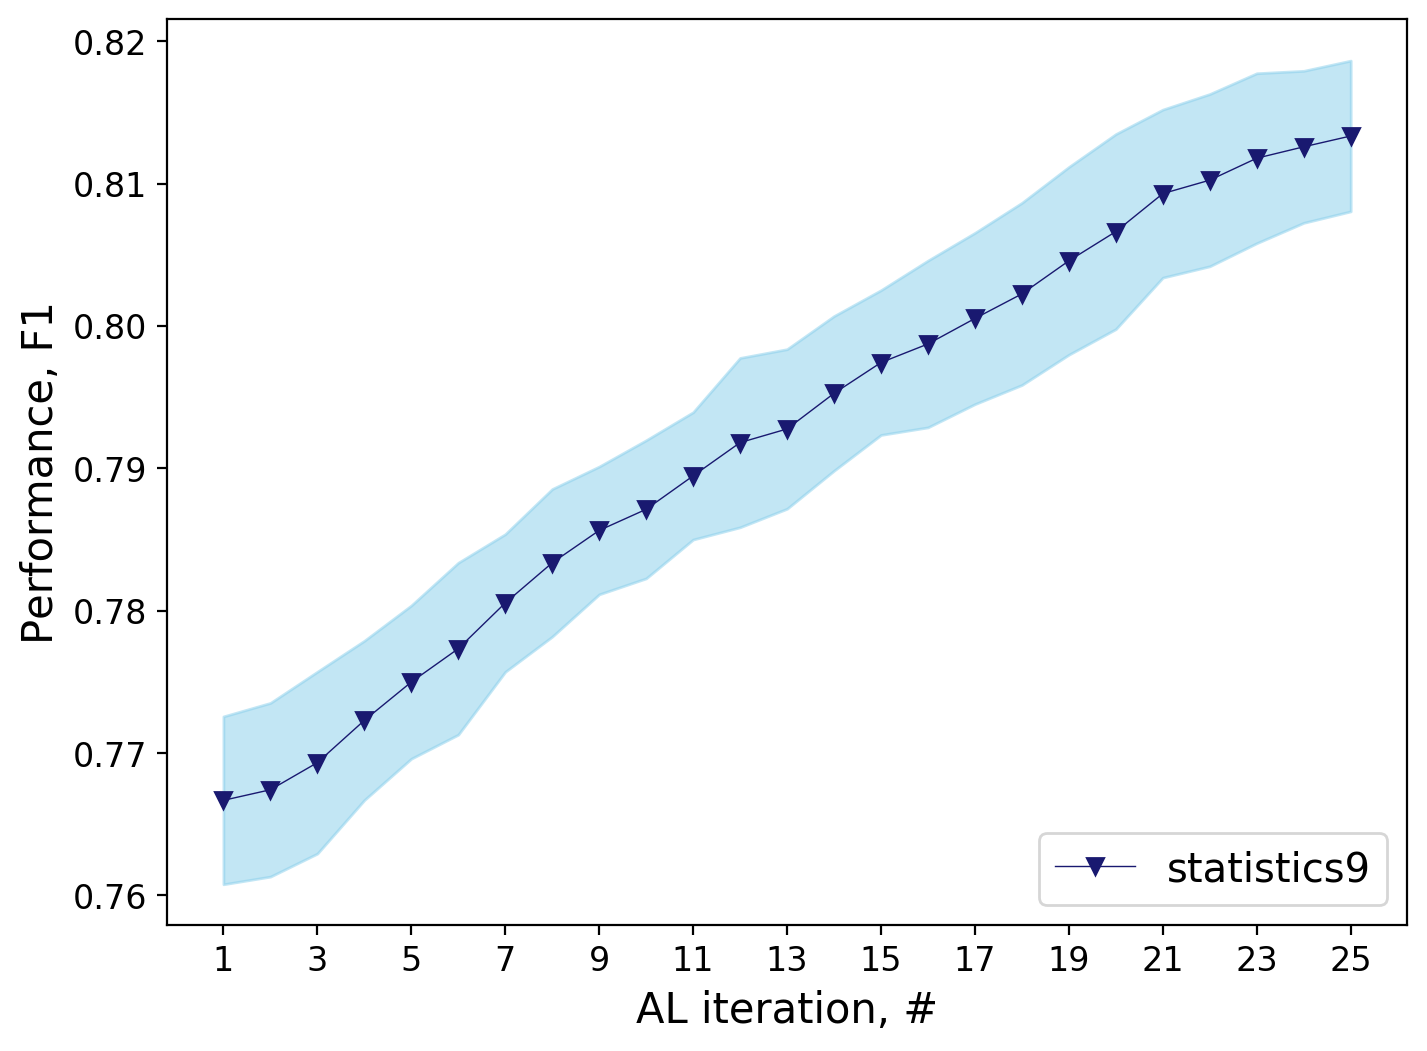

In [300]:
#from generate_chart import create_chart
create_chart('../workdir/experiments/crf/uncertainty', 'genia', save_dir='../workdir/')

In [239]:
max_samples_number = 100
repeats = 10
active_iterations = 60
N_SAMPLES_PER_AL_ITER = 100

for repeat in range(repeats):
    #task, emb_name, emb, strat_name, strat = experiments_to_try[experiment_id]
    strat_name = 'uncertainty'
    strat = lambda trn_ds, libact_model: UncertaintySampling(trn_ds, model=libact_model, method='lc')

    #path = os.path.join(models_path, task, emb_name, strat_name)
    #if os.path.exists(os.path.join(path, f'statistics{repeat}.json')):
        #print(f'statistics{repeat}.json already exists. Next')
        #continue

    print('Active learning strategy', strat_name)
    print('Repeat', repeat)

    #X_train, X_test, y_train, y_test, tag_dictionary = load_task(task)
    y_seed = y_train2y_seed(y_train, n_seeds_per_class=200)

    active_tagger = CRF_active(algorithm="lbfgs",
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=True)
    
    active_learn_alg_ctor = make_libact_strategy_ctor(lambda tr_ds: strat(tr_ds, active_tagger), max_samples_number=max_samples_number)
    
    active_learner = ActiveLearner1(active_learn_alg_ctor = active_learn_alg_ctor,
                            y_dtype = 'str',
                            X_full_dataset = X_train, 
                            y_full_dataset = y_seed,
                            X_test_dataset = X_test,
                            y_test_dataset = y_test,
                            model_evaluate=active_tagger,
                            eval_metrics=[f1_score],
                            rnd_start_steps=0,
                            rnd_start_samples=max_samples_number)                

    #statistics = emulate_active_learning2(y_train, active_learner, max_iterations=active_iterations,
    #                                     n_annotations_per_iter=N_SAMPLES_PER_AL_ITER, stats_path='../workdir/logs')
        
    statistics = emulate_active_learning(y_train, active_learner, max_iterations=active_iterations)
    print(statistics)
    #dump_file(statistics, path, f'statistics{repeat}.json')

Active learning strategy uncertainty
Repeat 0
Start emulating active learning.
Evaluation: {'f1_score': 0.7577083111063694}
Active learning iteration: #0
2020-03-25 11:32:22,560 - biomed_ie - INFO - Number of training samples: 1032
Performance: {'f1_score': 0.7650963597430407}
Active learning iteration: #1
2020-03-25 11:32:27,357 - biomed_ie - INFO - Number of training samples: 1132
Performance: {'f1_score': 0.7746857204254862}
Active learning iteration: #2
2020-03-25 11:32:32,142 - biomed_ie - INFO - Number of training samples: 1232
Performance: {'f1_score': 0.7808782176076141}
Active learning iteration: #3
2020-03-25 11:32:36,948 - biomed_ie - INFO - Number of training samples: 1332
Performance: {'f1_score': 0.7878067235974489}
Active learning iteration: #4
2020-03-25 11:32:41,949 - biomed_ie - INFO - Number of training samples: 1432
Performance: {'f1_score': 0.7916531516920748}
Active learning iteration: #5
2020-03-25 11:32:46,932 - biomed_ie - INFO - Number of training samples: 153

KeyboardInterrupt: 

## 